##  TODO:
- update the README, (starting from logbookreader probably)
- separate IME and USTC analysis
    - downside, I might want to change things in both
    - maybe I need to make shared functions to analyze/plot

In [2]:
from importlib import reload # to reload modules
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
from matplotlib import colormaps # colormaps
from matplotlib.colors import hsv_to_rgb
from matplotlib.legend_handler import HandlerLine2D

import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint
from adjustText import adjust_text

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau

# import time
# from timeout_decorator import timeout

import LoadBatch
reload(LoadBatch)
from LoadBatch import *
from SensorClasses import *
import Single_batch
reload(Single_batch)
from Single_batch import analysis_batch

verbose = False

In [3]:
# logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')

In [5]:
# PIXEL_SIZE = 0.0184 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
### I should just have many options for ranges and choose between those

### this is now in LoadBatch.py

### Load the dictionary of sensor names and runs
# dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

# logging.info(f"dictionary of the runs: \n{dict_of_runs.keys()}")
logging.info(f"dictionary of the batches: \n{dict_of_batches.keys()}")

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "noise", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

### charge fit folder
ROOT_fit_dir = "/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/ROOT_Langaus_fit/Charge_fit_results"

### presentation path
pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Presentations/2024-10-03 for Mengqing'

[INFO] - 	 dictionary of the batches: 
dict_keys([199, 100, 101, 201, 202, 203, 301, 401, 402, 403, 204, 406, 407, 408, 409, 410, 411, 205, 206, 413, 414, 501, 502, 504, 505, 601, 602, 603, 604, 605, 701, 702, 801, 802, 901, 902, 1001, 1002, 1101, 1102, 1201, 1202, 5031, 5032])


In [6]:
unique_names = []
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        if batch_object.S[S] is not None:
            for ch, sensor in batch_object.S[S].channels.items():
                if (sensor.name != '') and (sensor.name not in unique_names):
                    unique_names.append(sensor.name)
logging.info(f"{unique_names}")

for name in unique_names:
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:  
            if batch_object.S[S] is not None:
                for ch, sensor in batch_object.S[S].channels.items():
                    if (sensor.name == name):
                        if (sensor.voltage == 0) or (sensor.voltage is None): continue 
                        print(f"{sensor.name}, board: {sensor.board}\tV: {sensor.voltage}, angle: {batch_object.angle}°,", "temp: %.2f°C,"%batch_object.temperature, f"fluence: {sensor.fluence}, in batch {batch_object.batch_number}, {S}, {ch})")
    print('-'*100)

[INFO] - 	 ['MCP', 'IMEv3-W12-C2-2-2', 'IMEv3-W12-C3-1-4', 'CNM-R15973-W5-D138', 'CNM-R15973-W4-D168', 'IMEv3-W12-C3-1-5', 'USTC2.1-W17-P6-A', 'JSI-PP4-IMEv2-W7-6.5E14', 'JSI-B7-IMEv3-W16-8E14', 'JSI-B13-IMEv3-W16-2.5E15', 'JSI-B6-IMEv2-W7-1E14', 'JSI-PP1', 'CERN2-CH0-IMEv3-W12', 'CERN2-CH1-IMEv3-W12', 'CERN2-CH2-IMEv3-W12', 'JSI-B5-CNM-W3-2.5E15', 'CERN2-CH4-IMEv3-W16']


MCP, board: no_board	V: 2600, angle: nan°, temp: -31.20°C, fluence: 0, in batch 199, S1, Ch1)
MCP, board: no_board	V: 2600, angle: nan°, temp: -31.20°C, fluence: 0, in batch 199, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.87°C, fluence: 0, in batch 100, S1, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.87°C, fluence: 0, in batch 100, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -33.45°C, fluence: 0, in batch 101, S1, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -33.45°C, fluence: 0, in batch 101, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -31.75°C, fluence: 0, in batch 201, S1, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -31.75°C, fluence: 0, in batch 201, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.45°C, fluence: 0, in batch 202, S1, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.45°C, fluence: 0, in batch 202, S2, Ch1)
MCP, board: no_board	V: 2500, angle: 0.0°, temp: -32.58°C, f

In [7]:
unique_names

['MCP',
 'IMEv3-W12-C2-2-2',
 'IMEv3-W12-C3-1-4',
 'CNM-R15973-W5-D138',
 'CNM-R15973-W4-D168',
 'IMEv3-W12-C3-1-5',
 'USTC2.1-W17-P6-A',
 'JSI-PP4-IMEv2-W7-6.5E14',
 'JSI-B7-IMEv3-W16-8E14',
 'JSI-B13-IMEv3-W16-2.5E15',
 'JSI-B6-IMEv2-W7-1E14',
 'JSI-PP1',
 'CERN2-CH0-IMEv3-W12',
 'CERN2-CH1-IMEv3-W12',
 'CERN2-CH2-IMEv3-W12',
 'JSI-B5-CNM-W3-2.5E15',
 'CERN2-CH4-IMEv3-W16']

# USTC
looking specifically at one sensor

In [8]:
SAVE = False

In [9]:
USTC_list = []
USTC_dict = {'room_temp':[], 'angled':[], 'normal':[]}
this_sensor = 'USTC'
### maybe I can make all this weird iterations into a function
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        if batch_object.S[S] is not None:
            for ch, sensor in batch_object.S[S].channels.items():
                if this_sensor in sensor.name:
                    if batch_object.S[S].get_sensor(ch).voltage==0:
                        continue
                    if batch_object.batch_number == 411:  ### in batch 411 the sensors are "cut out"
                        continue
                    USTC_list.append((batch_object.batch_number, S, ch))
                    if batch_object.temperature<0 and batch_object.S[S].get_sensor('Ch1').voltage==2500 and batch_object.angle==0:
                        USTC_dict['normal'].append((batch_object.batch_number, S, ch))                
                    if batch_object.temperature>0:# and batch_object.S[S].get_sensor('Ch1').voltage==2500:
                        USTC_dict['room_temp'].append((batch_object.batch_number, S, ch))
                    if batch_object.angle>0:
                        USTC_dict['angled'].append((batch_object.batch_number, S, ch))

### I add the zero angles with same voltages in the 'angled' 403,406,407
### I changed my mind, it makes more sense if I can plot them individually,
### so I can distinguish them when I plot them together with the rest of the data

# batches,S,chs = zip(*USTC_list)
# for idx, batch in enumerate(batches):
#     if batch in (403,406,407):
#         USTC_dict['angled'].append((batches[idx],S[idx],chs[idx]))  

logging.info(f"{USTC_list}")

[INFO] - 	 [(301, 'S1', 'Ch2'), (301, 'S1', 'Ch3'), (401, 'S1', 'Ch2'), (401, 'S1', 'Ch3'), (402, 'S1', 'Ch2'), (402, 'S1', 'Ch3'), (403, 'S1', 'Ch2'), (403, 'S1', 'Ch3'), (406, 'S1', 'Ch2'), (406, 'S1', 'Ch3'), (407, 'S1', 'Ch2'), (407, 'S1', 'Ch3'), (408, 'S1', 'Ch2'), (408, 'S1', 'Ch3'), (409, 'S1', 'Ch2'), (409, 'S1', 'Ch3'), (410, 'S1', 'Ch2'), (410, 'S1', 'Ch3'), (413, 'S1', 'Ch2'), (413, 'S1', 'Ch3'), (414, 'S1', 'Ch2'), (414, 'S1', 'Ch3')]


In [10]:
for name in unique_names:
    if this_sensor in name:
        print(name)

USTC2.1-W17-P6-A


In [11]:
print(USTC_dict['room_temp'])
print(USTC_dict['normal'])
print(USTC_dict['angled']) # + 403,406,407

[(301, 'S1', 'Ch2'), (301, 'S1', 'Ch3'), (408, 'S1', 'Ch2'), (408, 'S1', 'Ch3'), (409, 'S1', 'Ch2'), (409, 'S1', 'Ch3'), (410, 'S1', 'Ch2'), (410, 'S1', 'Ch3')]
[(401, 'S1', 'Ch2'), (401, 'S1', 'Ch3'), (402, 'S1', 'Ch2'), (402, 'S1', 'Ch3'), (403, 'S1', 'Ch2'), (403, 'S1', 'Ch3'), (406, 'S1', 'Ch2'), (406, 'S1', 'Ch3'), (407, 'S1', 'Ch2'), (407, 'S1', 'Ch3')]
[(413, 'S1', 'Ch2'), (413, 'S1', 'Ch3'), (414, 'S1', 'Ch2'), (414, 'S1', 'Ch3')]


### Create an emtpy dataframe and later add values extracted that I want
added value that it's easier to extract batch number, oscilloscope and channel without repetition

#### Create empty dictionary to store the dataframes
and folder to save all of the plots

In [12]:
key_to_study = 'room_temp'
# key_to_study = 'normal'
# key_to_study = 'angled'
print("studying:", key_to_study)

batches_to_study = USTC_dict[key_to_study]

save_path = f'../various plots/{this_sensor}/{key_to_study}/'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

### I should save the dictionary and just reopen it to add the other data
USTC_file_name = os.path.join(f"../various plots/{this_sensor}","USTC_analysis_dict.pickle")
columns_df = ['name', 'board', 'voltage', 'current', 'MCP_voltage', 'temperature','temp_A','temp_B', 'angle','humidity', 'fluence', 'charge', 'charge_error', 'efficiency', 'time_resolution', 'time_resolution_error', 'comments', 'exclude']

print("TOTAL COLUMNS NUMBER:",len(columns_df))
### open file to read dictionary, if it doesn't exist make a new one
try:
    dict_analysis_USTC = read_pickle(USTC_file_name)
    df_analysis = dict_analysis_USTC[key_to_study]
    multi_index = df_analysis.index
except FileNotFoundError:
    logging.warning("file does not exist, creating new empty dictionary to store dataframes")
    dict_analysis_USTC = {}
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index, columns=columns_df)
except KeyError:
    logging.warning(f"{key_to_study} not studied yet, create empty dataframe")
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index, columns=columns_df)

### new dataframe, to erase the old one (if I change columns for example)
MAKE_NEW_DF = True
if MAKE_NEW_DF:
    logging.warning("Creating empty dataframe anyways")  # only for the single key_to_study
    multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope', 'channel'])
    df_analysis = pd.DataFrame(index=multi_index, columns=columns_df)

    
idx=pd.IndexSlice

[WARNING] - 	 Creating empty dataframe anyways


studying: room_temp
TOTAL COLUMNS NUMBER: 18


In [45]:
### apparently all the runs from 412 are empty, and for some reason I have to remove the unused level
    ### yes, but I removed them from the list of batches


## Calculating data
NEW WAY (using the Single_batch.py)

In [18]:

for this_batch in df_analysis.index.levels[0]: ### batches
    for S in df_analysis.index.levels[1]:        ### scopes
        DUTs = get_DUTs_from_channels(df_analysis.loc[idx[this_batch,S,:]].index)
        ### do the analsysis and get the 
        results_dict = analysis_batch(this_batch, dict_of_batches[this_batch], S, n_DUT=DUTs,
                      do_plots=False, show_plot=False, SAVE=False, CFD_comparison=False, fit_charge=False, return_results=True)
        
        ### now I just need a way to fill up the dataframe         
#         display(results_dict)
        name = results_dict.get('name', "no_sensor")
        board = results_dict.get('board', NO_BOARD)
        voltage = results_dict.get('voltage', 0)
        current = results_dict.get('current', 0)
        MCP_voltage = results_dict.get('MCP_voltage', 0)
        temperature = results_dict.get('temperature', 0)
        temp_A = results_dict.get('temp_A', [])
        temp_B = results_dict.get('temp_B', [])
        angle = results_dict.get('angle', 0)
        humidity = results_dict.get('humidity', 0)
        fluence = results_dict.get('fluence', 0)
        charge = results_dict.get('charge', 0)
        charge_error = results_dict.get('charge_error', 0)
        eff = results_dict.get('efficiency', 0)
        time_resolution = results_dict.get('time_resolution', 0)
        time_res_err = results_dict.get('time_res_err', 0)
        comments = results_dict.get('comments', {})
        
        df_analysis.loc[(this_batch,S,ch)] = [name, board, voltage, current, MCP_voltage, temperature, temp_A, temp_B,
                                              angle, humidity, fluence, charge, charge_error, eff, time_resolution, time_res_err,
                                              comments, False]
        
df_analysis.sort_values(by=['name','voltage']).copy()
dict_analysis_USTC[key_to_study] = df_analysis.copy()


[INFO] - 	 in analysis_batch(), analysing Batch: 301, S1
[INFO] - 	 Loading batch 301 	 Oscilloscope S1
[INFO] - 	 MCP: 2500 V, angle: 0.0°, temperature: 21.82°C
[INFO] - 	 in 'time_mask()': Fit parameters [ 8.96977356e+03 -5.87996255e+03  7.53326425e+01  5.44317667e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 7.86571482e+03 -5.91179180e+03  7.08370338e+01  2.72300810e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [  782.99674631 -5878.50803323    71.90583598     6.71977514]
[INFO] - 	 in analysis_batch(), Time resolution: 61.94ps +/- 0.77ps, (MCP: 36.52ps)
[INFO] - 	 in 'time_mask()': Fit parameters [  648.84473181 -5910.70208365    66.1721322      7.94713963]
[INFO] - 	 in analysis_batch(), Time resolution: 55.18ps +/- 0.83ps, (MCP: 36.52ps)
[INFO] - 	 in analysis_batch(), analysing Batch: 408, S1
[INFO] - 	 Loading batch 408 	 Oscilloscope S1


TOTAL TIME: 0 min and 23.87 sec


[INFO] - 	 MCP: 2500 V, angle: 0.0°, temperature: 21.45°C
[INFO] - 	 in 'time_mask()': Fit parameters [ 4.21521162e+03 -5.86461881e+03  6.93430566e+01  2.26519419e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.76667321e+03 -5.89896107e+03  6.72422249e+01  1.68122411e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.48422306e+02 -5.86236544e+03  6.43275637e+01  3.56247609e+00]
[INFO] - 	 in analysis_batch(), Time resolution: 52.96ps +/- 1.03ps, (MCP: 36.52ps)
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.85769041e+02 -5.89668937e+03  6.15032779e+01  4.93437312e+00]
[INFO] - 	 in analysis_batch(), Time resolution: 49.49ps +/- 1.14ps, (MCP: 36.52ps)
[INFO] - 	 in analysis_batch(), analysing Batch: 409, S1
[INFO] - 	 Loading batch 409 	 Oscilloscope S1


TOTAL TIME: 0 min and 11.38 sec


[INFO] - 	 MCP: 2500 V, angle: 0.0°, temperature: 21.73°C
[INFO] - 	 in 'time_mask()': Fit parameters [ 4.76678240e+03 -5.86495953e+03  6.45984678e+01  2.35503885e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 4.16427765e+03 -5.89669532e+03  6.20817371e+01  1.42182105e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [  361.58861451 -5863.1013143     59.42732599     6.45847528]
[INFO] - 	 in analysis_batch(), Time resolution: 46.88ps +/- 1.06ps, (MCP: 36.52ps)
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.13919986e+02 -5.89518669e+03  5.78972912e+01  4.70715609e+00]
[INFO] - 	 in analysis_batch(), Time resolution: 44.93ps +/- 1.12ps, (MCP: 36.52ps)
[INFO] - 	 in analysis_batch(), analysing Batch: 410, S1
[INFO] - 	 Loading batch 410 	 Oscilloscope S1


TOTAL TIME: 0 min and 12.84 sec


[INFO] - 	 MCP: 2600 V, angle: 0.0°, temperature: 21.80°C
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.68277200e+03 -5.85906089e+03  4.83115169e+01  1.35418823e-01]
[INFO] - 	 in 'time_mask()': Fit parameters [ 3.24473701e+03 -5.89042453e+03  4.63597885e+01  8.88162370e-02]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2.10670156e+02 -5.85738550e+03  4.42050273e+01  2.91096247e+00]
[INFO] - 	 in analysis_batch(), Time resolution: 41.02ps +/- 0.75ps, (MCP: 16.48ps)
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.76132332e+02 -5.89018819e+03  4.34623800e+01  1.90302722e+00]
[INFO] - 	 in analysis_batch(), Time resolution: 40.22ps +/- 0.84ps, (MCP: 16.48ps)


TOTAL TIME: 0 min and 6.91 sec


## Calculating data
(OLD WAY)

In [1]:
time_bins = 2000
transimpedance = 4700
threshold_charge = 4 #fC

SAVE = False
save_path = f'../various plots/{this_sensor}/{key_to_study}/'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

### I'm starting to think that putting the values in a list is not working
for this_batch in df_analysis.index.levels[0]: ### batches
    for S in df_analysis.index.levels[1]:        ### scopes
        ### get only the DUTs that I need
#         DUTs = get_DUT_from_index(list(df_analysis.loc[idx[this_batch,S,:]].index))
        df = load_batch(this_batch,S)
       
        print(f"MCP: {dict_of_batches[this_batch].S[S].channels['Ch1'].voltage} V, angle: {dict_of_batches[this_batch].angle:.1f}°", \
              f"temperature:{dict_of_batches[this_batch].temperature:.2f}°C, humidity:{dict_of_batches[this_batch].humidity:.2f}%")
        print('channels:', df_analysis.loc[idx[this_batch,S,:]].index)
        ### I could add a different way to go from ch2,ch3,ch4 to DUTs: 1,2,3
        for ch in df_analysis.loc[idx[this_batch,S,:]].index:      ### channels
            ### EXTRACTING DATA
            match ch:
                case 'Ch1': dut=-1
                case 'Ch2': dut=1
                case 'Ch3': dut=2
                case 'Ch4': dut=3
                case other: logging.error("wrong channel name")
            print(f"Batch:{this_batch}, Scope:{S}, Channel:{ch}")

            comments = set()

            geometry_cut = geometry_mask(df, DUT_number=dut, bins=bins_dict[this_batch], use='pulseheight')[0]
            if np.alltrue(geometry_cut):   ### this means the geometry_mask() failed 
                geometry_cut = geometry_mask(df, DUT_number=dut, bins=bins_dict[this_batch], use='time')[0]
                logging.info("using 'time' instead of 'pulseheight' for geometry_cut")
                comments.add("using time for geometry_cut")
            center_cut = geometry_mask(df, DUT_number=dut, bins=bins_dict[this_batch], only_select='center')[0]

            time_cut = time_mask(df, dut, bins=time_bins, sigmas=3, mask=geometry_cut, plot=False)[0]
#             larger_time_cut = time_mask(df, dut, bins=time_bins, sigmas=5, mask=geometry_cut, plot=False)[0]
            charge_cut = df[f'charge_{dut}']>threshold_charge

        ### I don't actually need pulseHeight cut here, I implicitly used to calculate the geometry cut
#             mins = find_min_btw_peaks(df[f"pulseHeight_{dut}"], bins='rice', plot=False)
#             pulseheight_cut = df[f'pulseHeight_{dut}']>mins
#             if np.alltrue(pulseheight_cut==False):
#                 pulseheight_cut = pd.Series(True, index=df.index)
#                 logging.error("pulseHeight cut failed")
#                 comments.add("no pulseHeight cut")

#             all_cut = np.logical_and(np.logical_and(geometry_cut,pulseheight_cut),time_cut)

#             transimpedance = dict_of_batches[this_batch].S[S].get_sensor(ch).transimpedance

            name = dict_of_batches[this_batch].S[S].get_sensor(ch).name
            board = dict_of_batches[this_batch].S[S].get_sensor(ch).board
            voltage = dict_of_batches[this_batch].S[S].get_sensor(ch).voltage
            current = dict_of_batches[this_batch].S[S].get_sensor(ch).current
            fluence = dict_of_batches[this_batch].S[S].get_sensor(ch).fluence
            MCP_voltage = dict_of_batches[this_batch].S[S].get_sensor('Ch1').voltage
            temp_A = dict_of_batches[this_batch].S[S].tempA
            temp_B = dict_of_batches[this_batch].S[S].tempB
            angle = dict_of_batches[this_batch].angle
            humidity = dict_of_batches[this_batch].humidity
            temperature = dict_of_batches[this_batch].temperature
            ### charge fit is calculated with ALL cuts (center, pulse, time)
            try:
                charge_fit_file = f"charge_fit_results_{this_batch}_{S}_{dut}.csv"
                charge_fit_df = pd.read_csv(os.path.join(ROOT_fit_dir,charge_fit_file), skiprows=1)
                charge = charge_fit_df["MPV"].iloc[0]
                charge_error = charge_fit_df["MPV_error"].iloc[0]
            except FileNotFoundError:
                logging.error("Charge file not found")
                charge, charge_error = -1, 0
                comments.add("Charge fit file not found")
            except:
                logging.error("Unknown error when loading charge fit")
                charge, charge_error = -1, 0
                comments.add("Charge fit error")
                        
            match MCP_voltage:  ### last MCP_voltage entry
                case 2500: 
                    MCP_resolution = 36.52 # +/- 0.81
                    MCP_error = 0.81
                case 2600: 
                    MCP_resolution = 16.48 # +/- 0.57
                    MCP_error = 0.57
                case 2800: 
                    MCP_resolution = 3.73  # +/- 1.33
                    MCP_error = 1.33
                case other: logging.error("Incorrect MCP voltage")    
                ### I think I should use only central area + charge_cut
            try:
                time_dict = time_mask(df, dut, bins=100, n_bootstrap=False, plot=True,
                                            mask=np.logical_and(np.logical_and(center_cut,charge_cut),time_cut))[1]
            ### I CALCULATE THE ERROR PROPAGATION TO THE TIME RESOLUTION
                time_resolution, time_res_err = error_propagation(time_dict['parameters'][2], time_dict['parameters_errors'][2],
                                                            MCP_resolution, MCP_error)
            except:
                logging.error("Time fit error")
                comments.add("Time fit error")
                time_resolution, time_res_err = 0, 0
            ### efficiency only calculated with center and time cuts
            eff = efficiency(df[f"charge_{dut}"].loc[np.logical_and(center_cut,time_cut)], threshold=threshold_charge)

            print(f"{time_resolution:.2f}ps +/- {time_res_err:.2f}ps, (MCP: {MCP_resolution}ps)")
#              ['name', 'board', 'voltage', 'MCP_voltage', 'temperature','temp_A', 'temp_B', angle','humidity', 'fluence', 'charge', 'charge_error', 'efficiency', 'time_resolution', 'time_resolution_error', 'comments', 'exclude']
            df_analysis.loc[(this_batch,S,ch)] = [name, board, voltage, current, MCP_voltage, temperature, temp_A, temp_B, angle, humidity, fluence, charge, charge_error, eff, time_resolution, time_res_err, comments, False]

df_analysis.sort_values(by=['name','voltage']).copy()
dict_analysis_USTC[key_to_study] = df_analysis.copy()


NameError: name 'this_sensor' is not defined

In [47]:
### select one value from the index channel
# df_analysis.loc[idx[:,:,'Ch2'],['charge']] ### DATAFRAME  
# df_analysis.loc[idx[:,:,'Ch2']]['charge']  ### SERIES
display(df_analysis)

name   board voltage   current  \
batch oscilloscope channel                                               
413   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -105  0.000001   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -105  0.000001   
414   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -100       0.0   

                           MCP_voltage temperature  \
batch oscilloscope channel                           
413   S1           Ch2            2800  -30.226389   
                   Ch3            2800  -30.226389   
414   S1           Ch2            2800  -31.858333   
                   Ch3            2800  -31.858333   

                                                                       temp_A  \
batch oscilloscope channel                                                      
413   S1           Ch2             [-29.1, -25.8, -28.9, -30.9, -31.9, -32.0]   
                   Ch3             [-29.1, -25.8, -28.9, -30.9, -31.9, -32.0]   
414   S1           Ch2      [-31.9, -31.9, -31.8, -31.8, -31.8, -31.7, -31...   
                   Ch3      [-31.9, -31.9, -31.8, -31.8, -31.8, -31.7, -31...   

                                                                       temp_B  \
batch oscilloscope channel                                                      
413   S1           Ch2             [-29.3, -26.0, -29.1, -31.2, -32.2, -32.3]   
                   Ch3             [-29.3, -26.0, -29.1, -31.2, -32.2, -32.3]   
414   S1           Ch2      [-32.2, -32.2, -32.1, -32.1, -32.1, -32.0, -31...   
                   Ch3      [-32.2, -32.2, -32.1, -32.1, -32.1, -32.0, -31...   

                           angle   humidity fluence   charge charge_error  \
batch oscilloscope channel                                                  
413   S1           Ch2       6.0  12.411111       0  26.7756      0.02766   
                   Ch3       6.0  12.411111       0  28.4153     0.023978   
414   S1           Ch2       6.0  10.233333       0  25.2191     0.024988   
                   Ch3       6.0  10.233333       0  26.6553     0.021182   

                           efficiency time_resolution time_resolution_error  \
batch oscilloscope channel                                                    
413   S1           Ch2      99.812258       40.646588               0.25192   
                   Ch3      99.795585       38.405908               0.24604   
414   S1           Ch2       99.74813       41.587283              0.259583   
                   Ch3      99.797876       39.662469              0.245938   

                           comments exclude  
batch oscilloscope channel                   
413   S1           Ch2           {}   False  
                   Ch3           {}   False  
414   S1           Ch2           {}   False  
                   Ch3           {}   False

In [48]:
dict_analysis_USTC["room_temp"].loc[(410,'S1','Ch2')]['exclude'] = True
dict_analysis_USTC["room_temp"].loc[(410,'S1','Ch3')]['exclude'] = True

# dict_analysis_USTC["room_temp"]['current'] = dict_analysis_USTC["room_temp"]['current'].map('{:.2E}'.format)
display(dict_analysis_USTC["room_temp"])

name   board voltage   current  \
batch oscilloscope channel                                               
301   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -120       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -120       0.0   
408   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -150       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -150       0.0   
409   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -165  0.000002   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -165  0.000002   
410   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -165  0.000002   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -165  0.000002   

                           MCP_voltage temperature  \
batch oscilloscope channel                           
301   S1           Ch2            2500   21.816667   
                   Ch3            2500   21.816667   
408   S1           Ch2            2500       21.45   
                   Ch3            2500       21.45   
409   S1           Ch2            2500   21.733333   
                   Ch3            2500   21.733333   
410   S1           Ch2            2600        21.8   
                   Ch3            2600        21.8   

                                                          temp_A  \
batch oscilloscope channel                                         
301   S1           Ch2      [21.8, 21.8, 21.7, 21.7, 21.7, 21.7]   
                   Ch3      [21.8, 21.8, 21.7, 21.7, 21.7, 21.7]   
408   S1           Ch2                        [21.2, 21.4, 21.5]   
                   Ch3                        [21.2, 21.4, 21.5]   
409   S1           Ch2                        [21.7, 21.6, 21.7]   
                   Ch3                        [21.7, 21.6, 21.7]   
410   S1           Ch2                              [21.7, 21.7]   
                   Ch3                              [21.7, 21.7]   

                                                          temp_B angle  \
batch oscilloscope channel                                               
301   S1           Ch2      [21.9, 21.9, 21.9, 21.9, 21.9, 21.9]   0.0   
                   Ch3      [21.9, 21.9, 21.9, 21.9, 21.9, 21.9]   0.0   
408   S1           Ch2                        [21.4, 21.5, 21.7]   0.0   
                   Ch3                        [21.4, 21.5, 21.7]   0.0   
409   S1           Ch2                        [21.8, 21.8, 21.8]   0.0   
                   Ch3                        [21.8, 21.8, 21.8]   0.0   
410   S1           Ch2                              [21.9, 21.9]   0.0   
                   Ch3                              [21.9, 21.9]   0.0   

                           humidity fluence   charge charge_error efficiency  \
batch oscilloscope channel                                                     
301   S1           Ch2          0.0       0  10.9989     0.009863  99.667949   
                   Ch3          0.0       0  11.5061     0.011544    99.7573   
408   S1           Ch2          0.0       0  16.1826     0.019563  99.750854   
                   Ch3          0.0       0  16.9421     0.022779  99.723805   
409   S1           Ch2          0.0       0  20.6596     0.021278  99.715061   
                   Ch3          0.0       0  21.8987      0.02477  99.781676   
410   S1           Ch2          0.0       0  20.6909     0.028019  99.693107   
                   Ch3          0.0       0  21.9334     0.032442  99.736587   

                           time_resolution time_resolution_error comments  \
batch oscilloscope channel                                                  
301   S1           Ch2           64.097782              0.611129       {}   
                   Ch3           58.112826              0.668236       {}   
408   S1           Ch2           55.552074              0.798407       {}   
                   Ch3           53.153903              0.869019       {}   
409   S1           Ch2           50.449571              0.822976       {}

In [49]:
dict_analysis_USTC["normal"].loc[(406,'S1','Ch2')]['exclude'] = True
dict_analysis_USTC["normal"].loc[(406,'S1','Ch3')]['exclude'] = True

display(dict_analysis_USTC["normal"])

name   board voltage   current  \
batch oscilloscope channel                                               
401   S1           Ch2      USTC2.1-W17-P6-A  CERN-3     -80       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3     -80       0.0   
402   S1           Ch2      USTC2.1-W17-P6-A  CERN-3     -90       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3     -90       0.0   
403   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
406   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
407   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -105  0.000002   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -105  0.000002   

                           MCP_voltage temperature  \
batch oscilloscope channel                           
401   S1           Ch2            2500  -30.555556   
                   Ch3            2500  -30.555556   
402   S1           Ch2            2500  -29.928571   
                   Ch3            2500  -29.928571   
403   S1           Ch2            2500      -31.22   
                   Ch3            2500      -31.22   
406   S1           Ch2            2500      -30.17   
                   Ch3            2500      -30.17   
407   S1           Ch2            2500     -30.025   
                   Ch3            2500     -30.025   

                                                                       temp_A  \
batch oscilloscope channel                                                      
401   S1           Ch2      [-30.0, -30.0, -30.0, -30.0, -31.0, -31.0, -31...   
                   Ch3      [-30.0, -30.0, -30.0, -30.0, -31.0, -31.0, -31...   
402   S1           Ch2      [-31.0, -31.0, -28.8, -28.3, -29.5, -29.5, -30.5]   
                   Ch3      [-31.0, -31.0, -28.8, -28.3, -29.5, -29.5, -30.5]   
403   S1           Ch2                    [-30.9, -31.1, -31.0, -31.0, -30.8]   
                   Ch3                    [-30.9, -31.1, -31.0, -31.0, -30.8]   
406   S1           Ch2                    [-30.0, -30.0, -29.9, -29.9, -29.9]   
                   Ch3                    [-30.0, -30.0, -29.9, -29.9, -29.9]   
407   S1           Ch2      [-29.8, -29.8, -29.8, -29.8, -29.8, -29.8, -29...   
                   Ch3      [-29.8, -29.8, -29.8, -29.8, -29.8, -29.8, -29...   

                                                                       temp_B  \
batch oscilloscope channel                                                      
401   S1           Ch2      [-30.0, -30.0, -30.0, -30.0, -31.0, -31.0, -31...   
                   Ch3      [-30.0, -30.0, -30.0, -30.0, -31.0, -31.0, -31...   
402   S1           Ch2      [-31.0, -31.0, -28.8, -28.8, -29.9, -29.9, -31.0]   
                   Ch3      [-31.0, -31.0, -28.8, -28.8, -29.9, -29.9, -31.0]   
403   S1           Ch2                    [-31.4, -31.6, -31.5, -31.5, -31.4]   
                   Ch3                    [-31.4, -31.6, -31.5, -31.5, -31.4]   
406   S1           Ch2                    [-30.5, -30.5, -30.4, -30.3, -30.3]   
                   Ch3                    [-30.5, -30.5, -30.4, -30.3, -30.3]   
407   S1           Ch2      [-30.3, -30.3, -30.3, -30.2, -30.2, -30.2, -30...   
                   Ch3      [-30.3, -30.3, -30.3, -30.2, -30.2, -30.2, -30...   

                           angle humidity fluence   charge charge_error  \
batch oscilloscope channel                                                
401   S1           Ch2       0.0      0.0       0  17.0233     0.011854   
                   Ch3       0.0      0.0       0  17.7315     0.011411   
402   S1           Ch2       0.0      0.0       0  19.4495     0.014603   
                   Ch3       0.0      0.0       0  20.1922     0.013879   
403   S1           Ch2       0.0      0.0       0  23.9057     0.019953   
                   Ch3       0.

In [50]:
display(dict_analysis_USTC["angled"])

name   board voltage   current  \
batch oscilloscope channel                                               
413   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -105  0.000001   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -105  0.000001   
414   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -100       0.0   

                           MCP_voltage temperature  \
batch oscilloscope channel                           
413   S1           Ch2            2800  -30.226389   
                   Ch3            2800  -30.226389   
414   S1           Ch2            2800  -31.858333   
                   Ch3            2800  -31.858333   

                                                                       temp_A  \
batch oscilloscope channel                                                      
413   S1           Ch2             [-29.1, -25.8, -28.9, -30.9, -31.9, -32.0]   
                   Ch3             [-29.1, -25.8, -28.9, -30.9, -31.9, -32.0]   
414   S1           Ch2      [-31.9, -31.9, -31.8, -31.8, -31.8, -31.7, -31...   
                   Ch3      [-31.9, -31.9, -31.8, -31.8, -31.8, -31.7, -31...   

                                                                       temp_B  \
batch oscilloscope channel                                                      
413   S1           Ch2             [-29.3, -26.0, -29.1, -31.2, -32.2, -32.3]   
                   Ch3             [-29.3, -26.0, -29.1, -31.2, -32.2, -32.3]   
414   S1           Ch2      [-32.2, -32.2, -32.1, -32.1, -32.1, -32.0, -31...   
                   Ch3      [-32.2, -32.2, -32.1, -32.1, -32.1, -32.0, -31...   

                           angle   humidity fluence   charge charge_error  \
batch oscilloscope channel                                                  
413   S1           Ch2       6.0  12.411111       0  26.7756      0.02766   
                   Ch3       6.0  12.411111       0  28.4153     0.023978   
414   S1           Ch2       6.0  10.233333       0  25.2191     0.024988   
                   Ch3       6.0  10.233333       0  26.6553     0.021182   

                           efficiency time_resolution time_resolution_error  \
batch oscilloscope channel                                                    
413   S1           Ch2      99.812258       40.646588               0.25192   
                   Ch3      99.795585       38.405908               0.24604   
414   S1           Ch2       99.74813       41.587283              0.259583   
                   Ch3      99.797876       39.662469              0.245938   

                           comments exclude  
batch oscilloscope channel                   
413   S1           Ch2           {}   False  
                   Ch3           {}   False  
414   S1           Ch2           {}   False  
                   Ch3           {}   False

### Save the data
save the dictionary of dataframes, should be done after running EACH 'key_to_study'

In [51]:
with open(USTC_file_name, 'wb') as f:
    pickle.dump(dict_analysis_USTC, f)

### Bias voltage vs time resolution

#### Time resolution:
$$
\Large \sigma_{dut+MCP}^2 = \sigma_{dut}^2 + \sigma_{MCP}^2 \\
\Large \downarrow \\
\Large \sigma_{dut} = \sqrt{\sigma_{dut+MCP}^2-\sigma_{MCP}^2}
$$

# Plots

In [52]:
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_marker("")



In [63]:
BATCH_LABELS = True
if BATCH_LABELS:
    if_labels = "with_labels"
else:
    if_labels = ""

markers = ('o','v','s','*','X','P','D','2')
colormap = ['k','b','g','r','orange','yellow','purple']

USTC_colormap = [colormaps["Purples"](.8), colormaps["Purples"](.5),
                 colormaps["Reds"](.8), colormaps["Reds"](.4),
                 colormaps["Greens"](.8), colormaps["Greens"](.5)]


### general common arguments for plotting
marker_settings = {'markersize':8, 'alpha':.7, 'mfc':'none'}

### putting plots together

In [64]:
labels_for_keys = {'room_temp':'20°C  angle: 0°', 
                   'normal':'-30°C  angle: 0°',
                   'angled':'-30°C  angle: 6°'}

dut_labels = ["pad1", "pad2"]

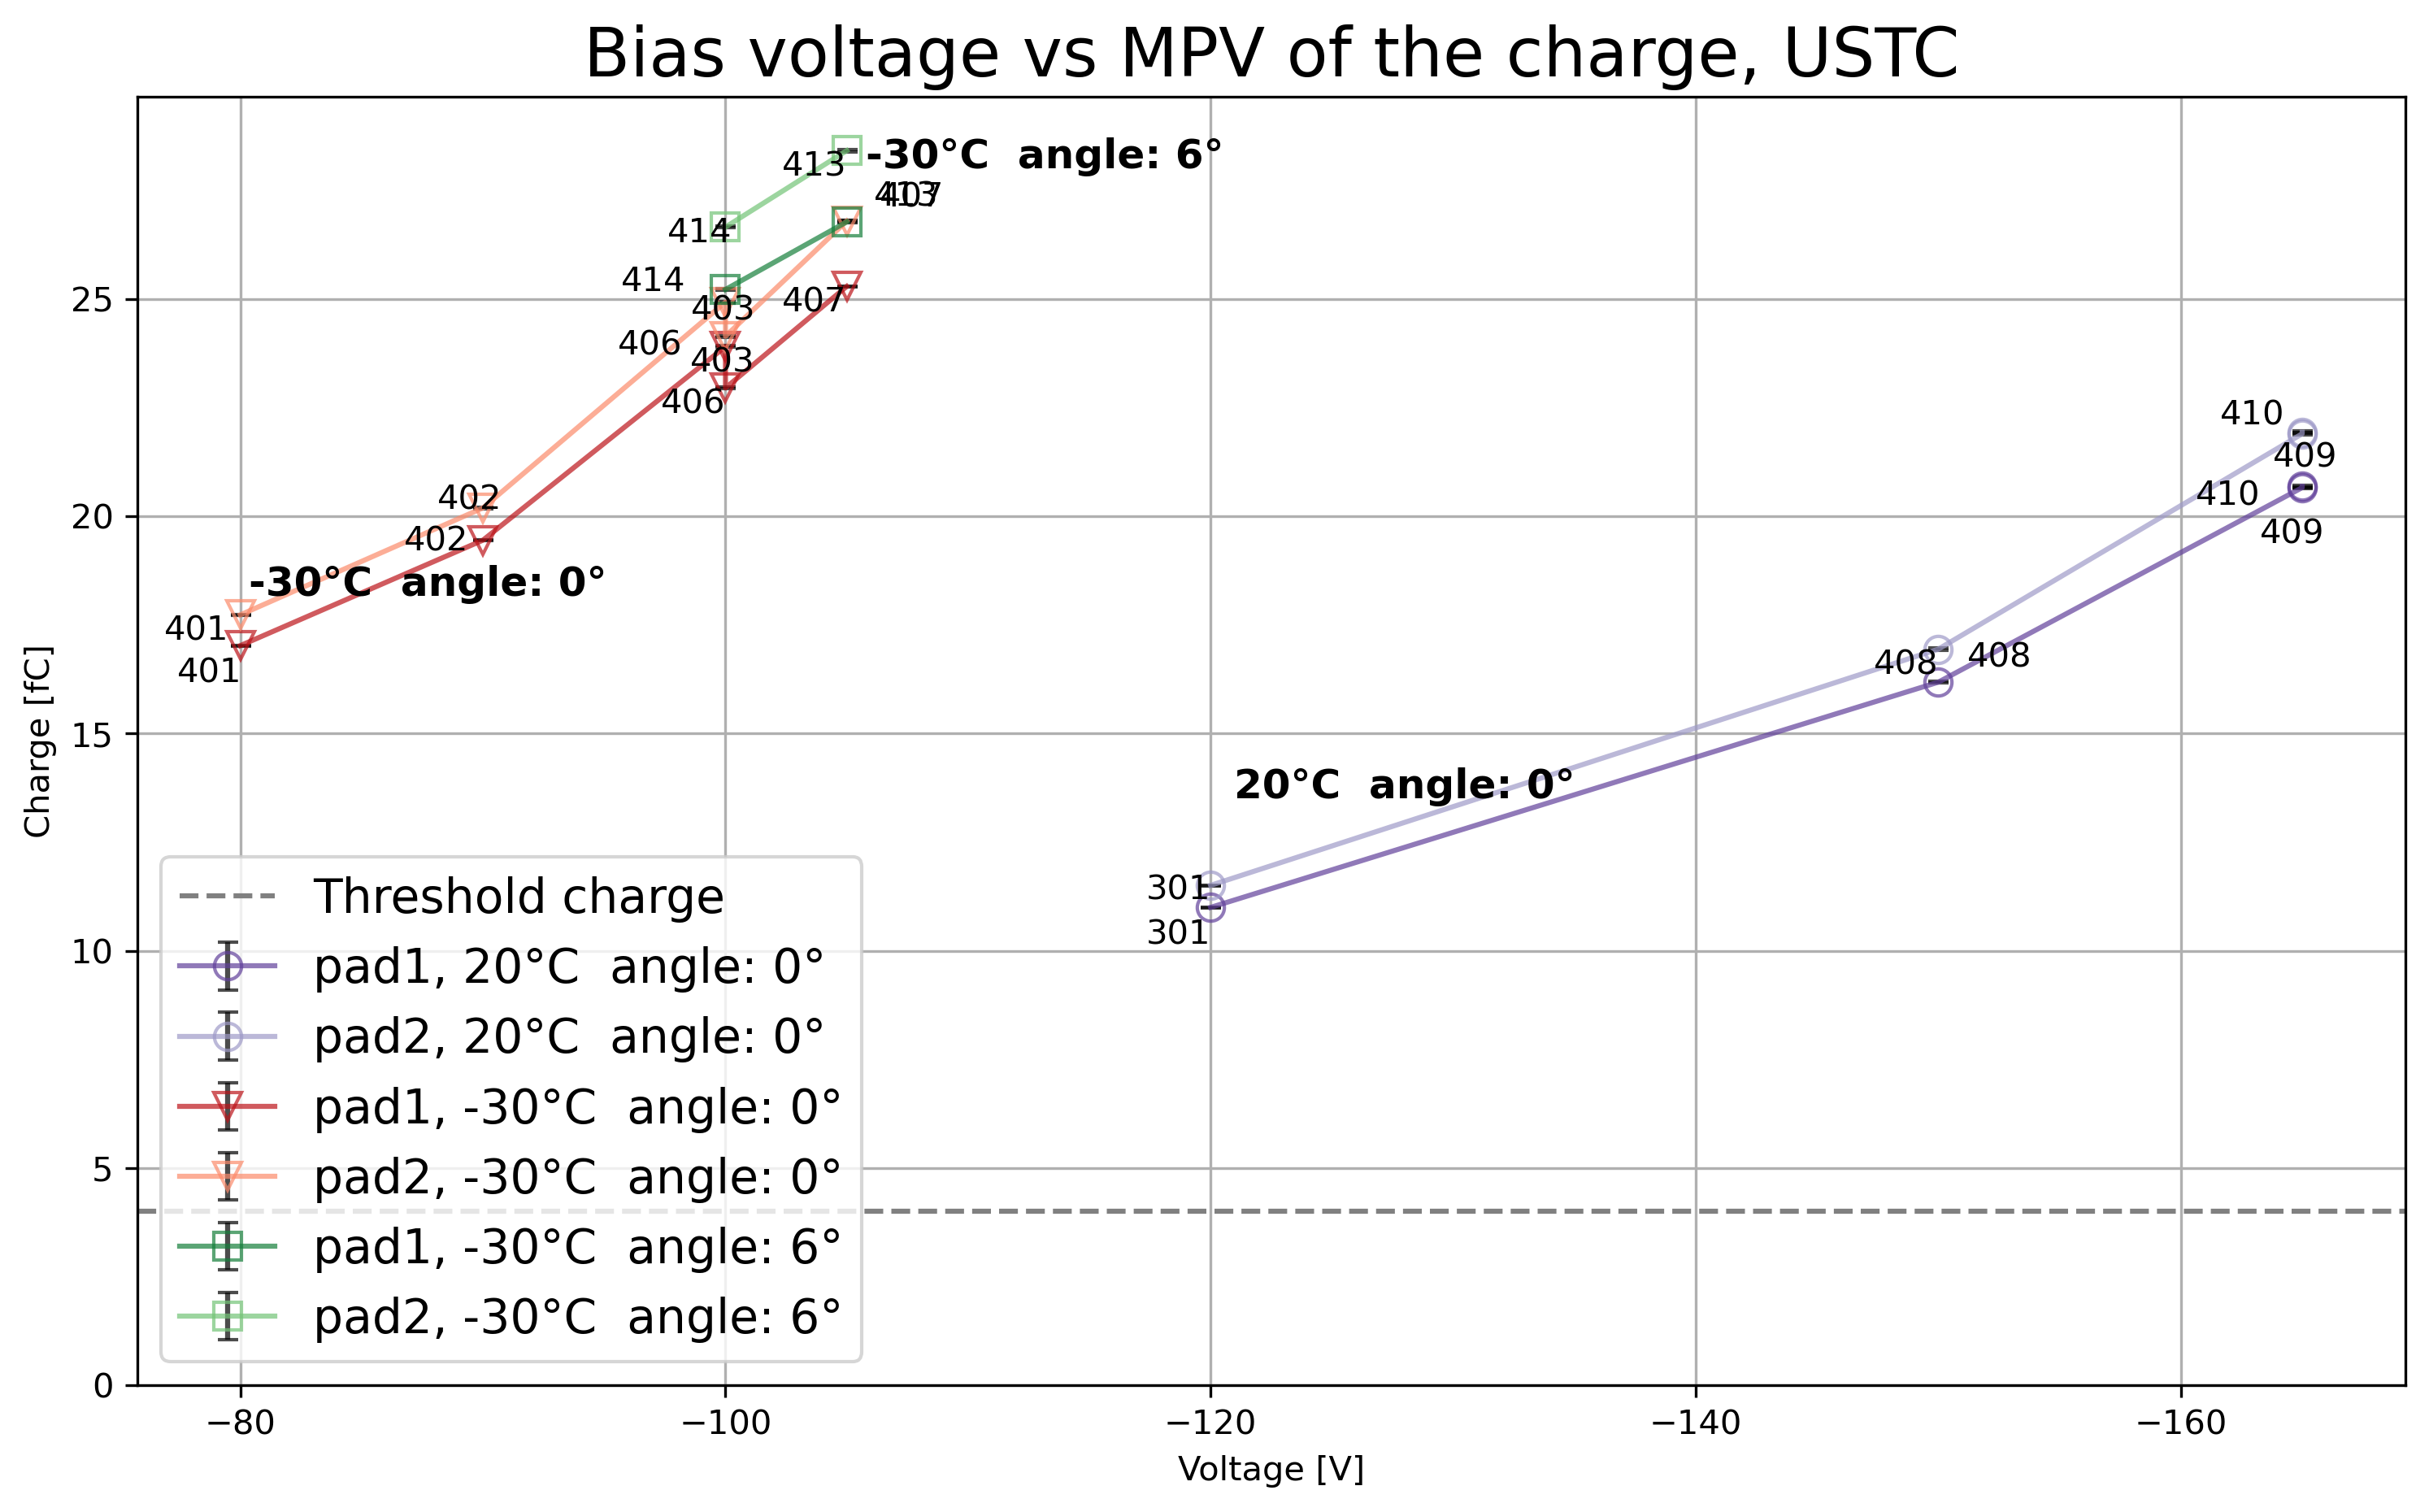

In [65]:
### CHARGE

fig, ax = plt.subplots(figsize=(12,7), dpi=300)

list_of_texts = []
#     print(sensor_name)
for j,key in enumerate(['room_temp', 'normal', 'angled']):#, 'irradiated_2800']):#, 'angled', 'angled_irradiated']):
#         print(key)
    df_analysis = dict_analysis_USTC[key]
#     df_analysis = df_analysis.loc[df_analysis['exclude']==False]
#     df_analysis = df_analysis.loc[df_analysis['name']==sensor_name]

    for k,ch in enumerate(df_analysis.index.unique(2)):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        charge = np.array(df_analysis.loc[idx[:,:,ch]]['charge'])
        charge_error = np.array(df_analysis.loc[idx[:,:,ch]]['charge_error'])
        batch_labels = np.array(df_analysis.loc[:,:,ch].index.get_level_values('batch'))

        ax.errorbar(voltage, charge, yerr=charge_error,
                    marker=markers[j], color=USTC_colormap[2*j+k], ecolor='k', capsize=3,
                    label=f"{dut_labels[k]}, {labels_for_keys[key]}", **marker_settings)
        if BATCH_LABELS:
            for x,y,label in zip(voltage,charge,batch_labels):
                list_of_texts.append(ax.text(x, y, label))
    list_of_texts.append(ax.text(np.mean(voltage[0:2]), np.mean(charge[0:2]), labels_for_keys[key],
                                 fontsize='large', weight='bold'))
    
ax.axhline(threshold_charge, linestyle='--', color='grey', label="Threshold charge")

ax.set_title(f"Bias voltage vs MPV of the charge, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Charge [fC]")
ax.set_ylim(0,None)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=14, loc='lower left')

adjust_text(list_of_texts)

if SAVE:
    fig.savefig(f"../various plots/{this_sensor}/USTC_plots_together_voltage_charge_{if_labels}.png", bbox_inches='tight')

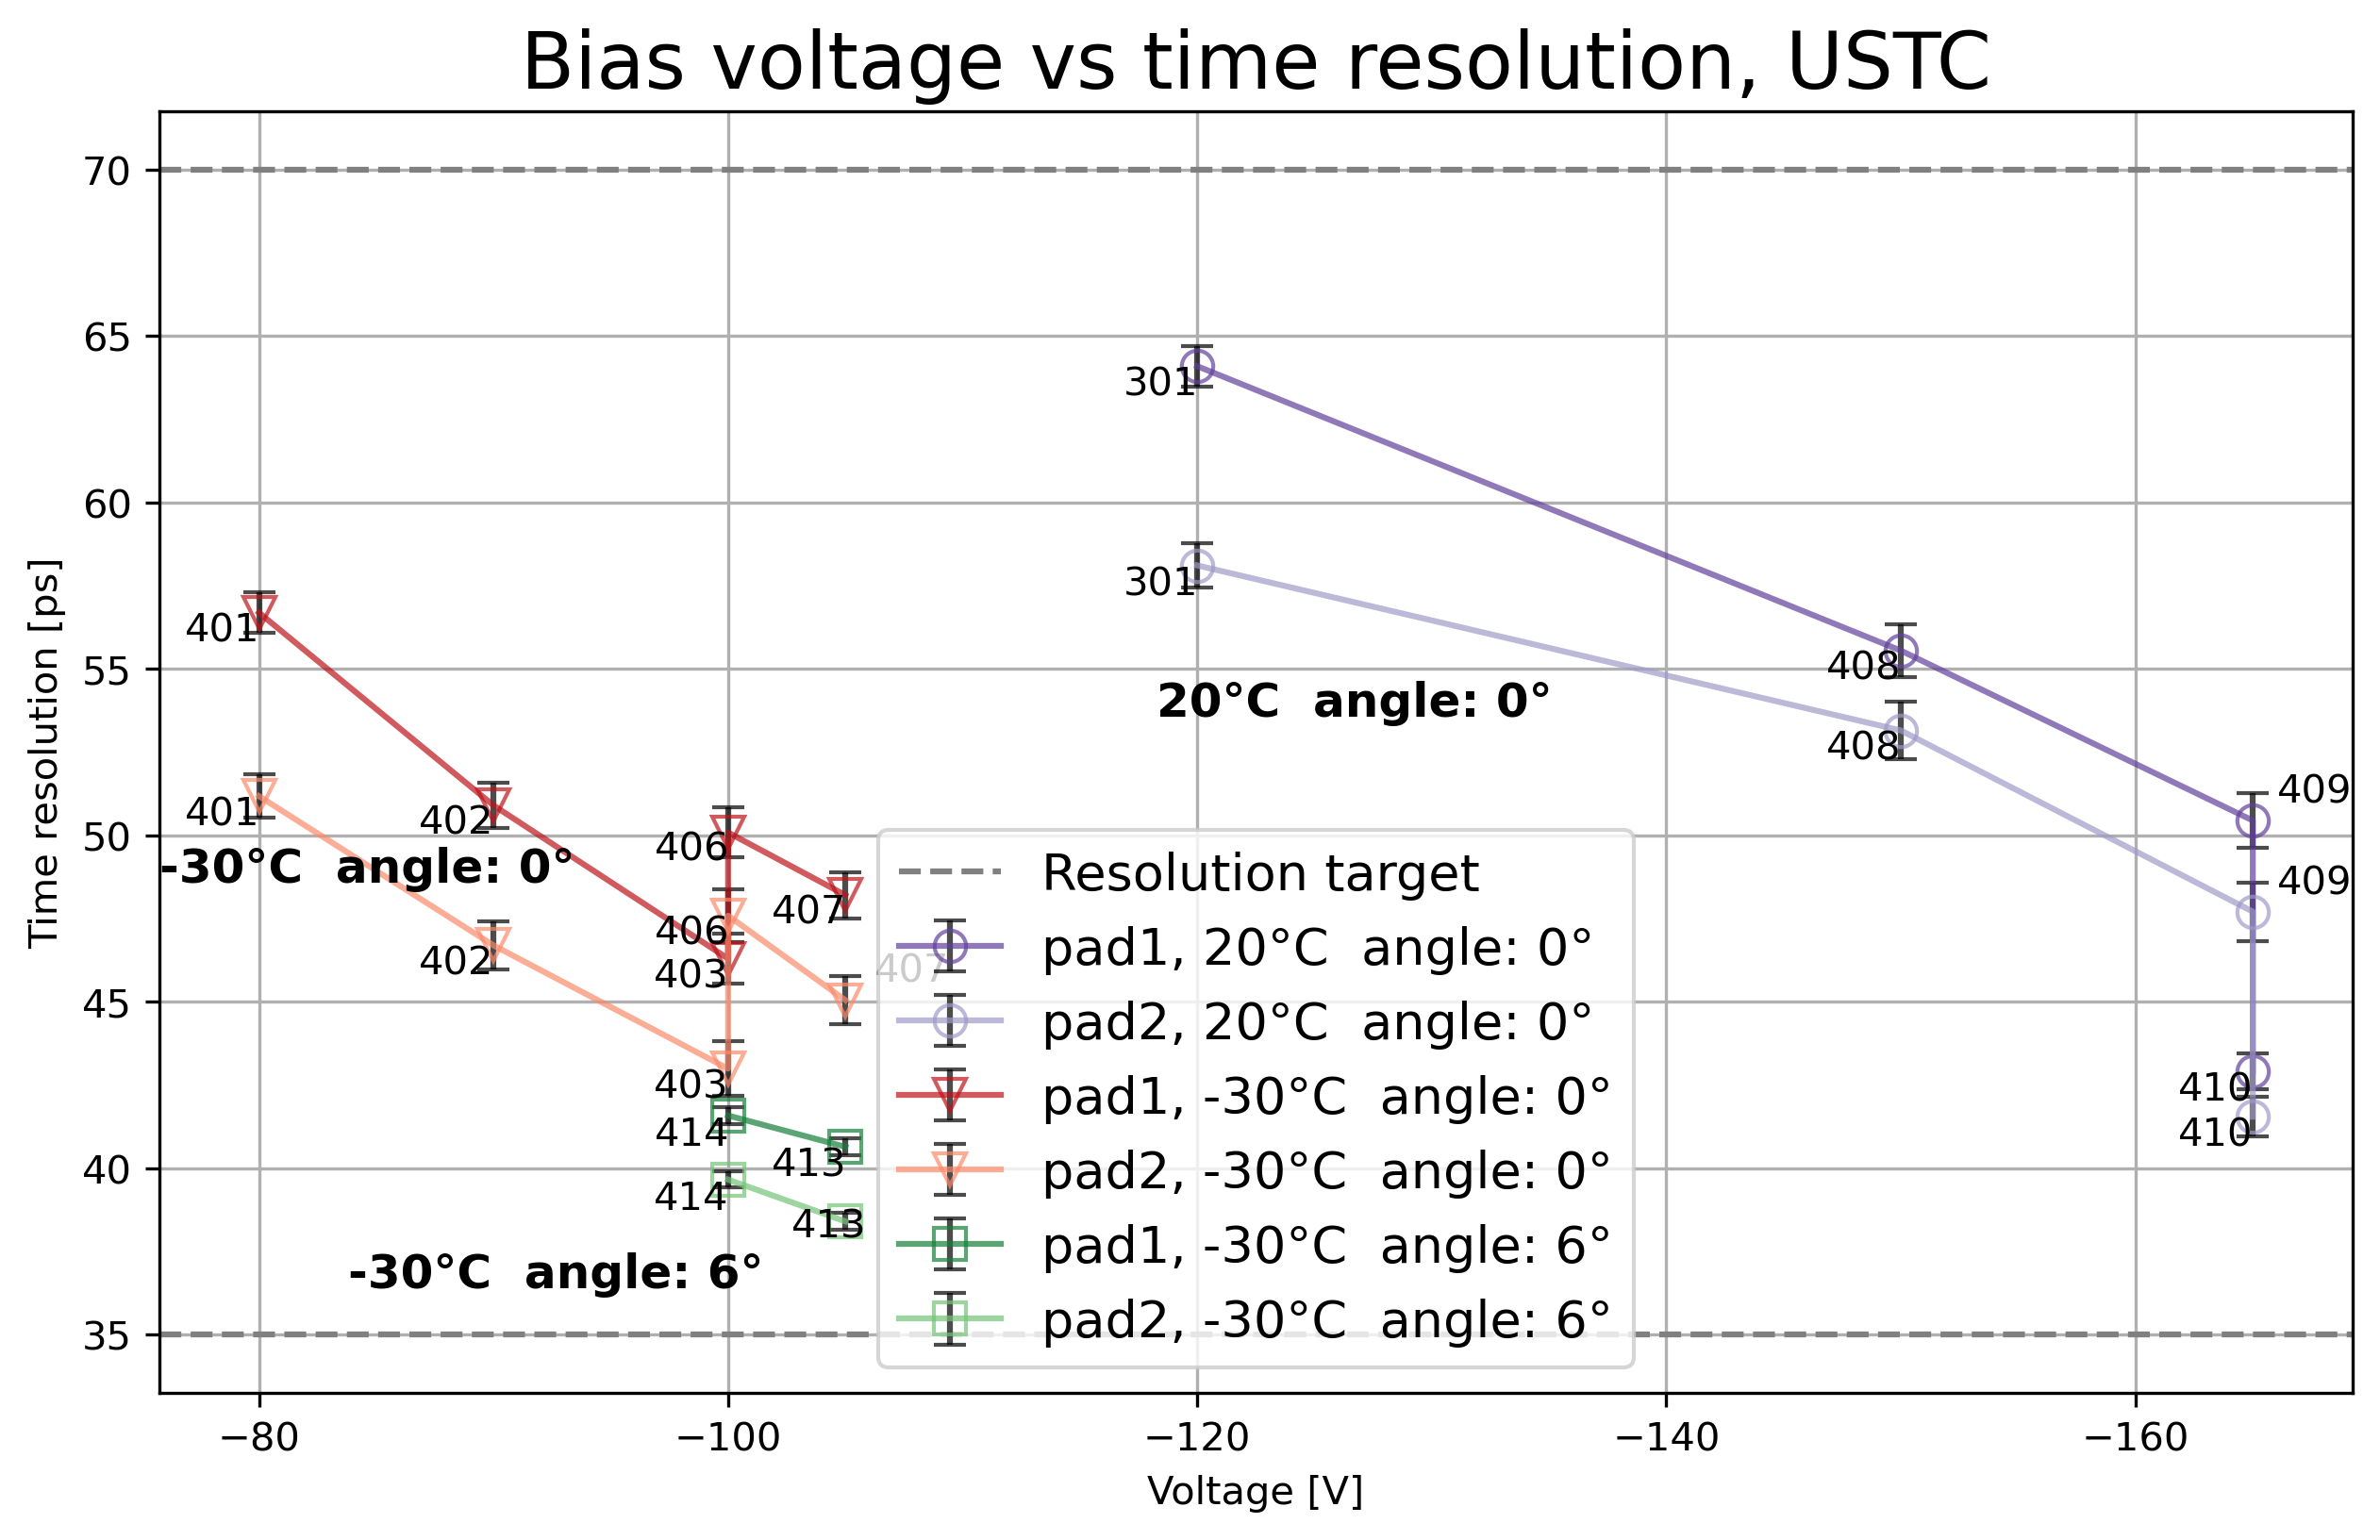

In [66]:
## TIME RESOLUTION

fig, ax = plt.subplots(figsize=(10,6), dpi=300)

# labels = ['room temperature', '-30°C','angle: 6° (MCP:2800V)']

list_of_texts = []
for j,key in enumerate(['room_temp', 'normal','angled']):
    df_analysis = dict_analysis_USTC[key]
#     df_analysis = df_analysis.loc[df_analysis['exclude']==False]
    
    for k,ch in enumerate(df_analysis.index.unique(2)):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        time = np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution'])
        time_err = np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution_error'])
        batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))

        ax.errorbar(voltage, time, yerr=time_err, ecolor='k', capsize=4,
            marker=markers[j], color=USTC_colormap[2*j+k],
            label=f"{dut_labels[k]}, {labels_for_keys[key]}", **marker_settings)
        ### list of all 
        if BATCH_LABELS:
            for x,y,label in zip(voltage,time,batch_labels):
                list_of_texts.append(ax.text(x, y, label))
    list_of_texts.append(ax.text(np.mean(voltage[0:2]), np.mean(time[0:2]-1), labels_for_keys[key],
                                 fontsize='large', weight='bold'))
            
ax.axhline(35, linestyle='--', color='grey', label="Resolution target")
ax.axhline(70, linestyle='--', color='grey')

ax.set_title(f"Bias voltage vs time resolution, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Time resolution [ps]")
# ax.set_ylim(30,75)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=13)

adjust_text(list_of_texts)

if SAVE:
    fig.savefig(f"../various plots/{this_sensor}/USTC_plots_together_voltage_time_res_{if_labels}.png", bbox_inches='tight')


In [67]:
display(dict_analysis_USTC['normal'])

name   board voltage   current  \
batch oscilloscope channel                                               
401   S1           Ch2      USTC2.1-W17-P6-A  CERN-3     -80       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3     -80       0.0   
402   S1           Ch2      USTC2.1-W17-P6-A  CERN-3     -90       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3     -90       0.0   
403   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
406   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -100       0.0   
407   S1           Ch2      USTC2.1-W17-P6-A  CERN-3    -105  0.000002   
                   Ch3      USTC2.1-W17-P6-A  CERN-3    -105  0.000002   

                           MCP_voltage temperature  \
batch oscilloscope channel                           
401   S1           Ch2            2500  -30.555556   
                   Ch3            2500  -30.555556   
402   S1           Ch2            2500  -29.928571   
                   Ch3            2500  -29.928571   
403   S1           Ch2            2500      -31.22   
                   Ch3            2500      -31.22   
406   S1           Ch2            2500      -30.17   
                   Ch3            2500      -30.17   
407   S1           Ch2            2500     -30.025   
                   Ch3            2500     -30.025   

                                                                       temp_A  \
batch oscilloscope channel                                                      
401   S1           Ch2      [-30.0, -30.0, -30.0, -30.0, -31.0, -31.0, -31...   
                   Ch3      [-30.0, -30.0, -30.0, -30.0, -31.0, -31.0, -31...   
402   S1           Ch2      [-31.0, -31.0, -28.8, -28.3, -29.5, -29.5, -30.5]   
                   Ch3      [-31.0, -31.0, -28.8, -28.3, -29.5, -29.5, -30.5]   
403   S1           Ch2                    [-30.9, -31.1, -31.0, -31.0, -30.8]   
                   Ch3                    [-30.9, -31.1, -31.0, -31.0, -30.8]   
406   S1           Ch2                    [-30.0, -30.0, -29.9, -29.9, -29.9]   
                   Ch3                    [-30.0, -30.0, -29.9, -29.9, -29.9]   
407   S1           Ch2      [-29.8, -29.8, -29.8, -29.8, -29.8, -29.8, -29...   
                   Ch3      [-29.8, -29.8, -29.8, -29.8, -29.8, -29.8, -29...   

                                                                       temp_B  \
batch oscilloscope channel                                                      
401   S1           Ch2      [-30.0, -30.0, -30.0, -30.0, -31.0, -31.0, -31...   
                   Ch3      [-30.0, -30.0, -30.0, -30.0, -31.0, -31.0, -31...   
402   S1           Ch2      [-31.0, -31.0, -28.8, -28.8, -29.9, -29.9, -31.0]   
                   Ch3      [-31.0, -31.0, -28.8, -28.8, -29.9, -29.9, -31.0]   
403   S1           Ch2                    [-31.4, -31.6, -31.5, -31.5, -31.4]   
                   Ch3                    [-31.4, -31.6, -31.5, -31.5, -31.4]   
406   S1           Ch2                    [-30.5, -30.5, -30.4, -30.3, -30.3]   
                   Ch3                    [-30.5, -30.5, -30.4, -30.3, -30.3]   
407   S1           Ch2      [-30.3, -30.3, -30.3, -30.2, -30.2, -30.2, -30...   
                   Ch3      [-30.3, -30.3, -30.3, -30.2, -30.2, -30.2, -30...   

                           angle humidity fluence   charge charge_error  \
batch oscilloscope channel                                                
401   S1           Ch2       0.0      0.0       0  17.0233     0.011854   
                   Ch3       0.0      0.0       0  17.7315     0.011411   
402   S1           Ch2       0.0      0.0       0  19.4495     0.014603   
                   Ch3       0.0      0.0       0  20.1922     0.013879   
403   S1           Ch2       0.0      0.0       0  23.9057     0.019953   
                   Ch3       0.

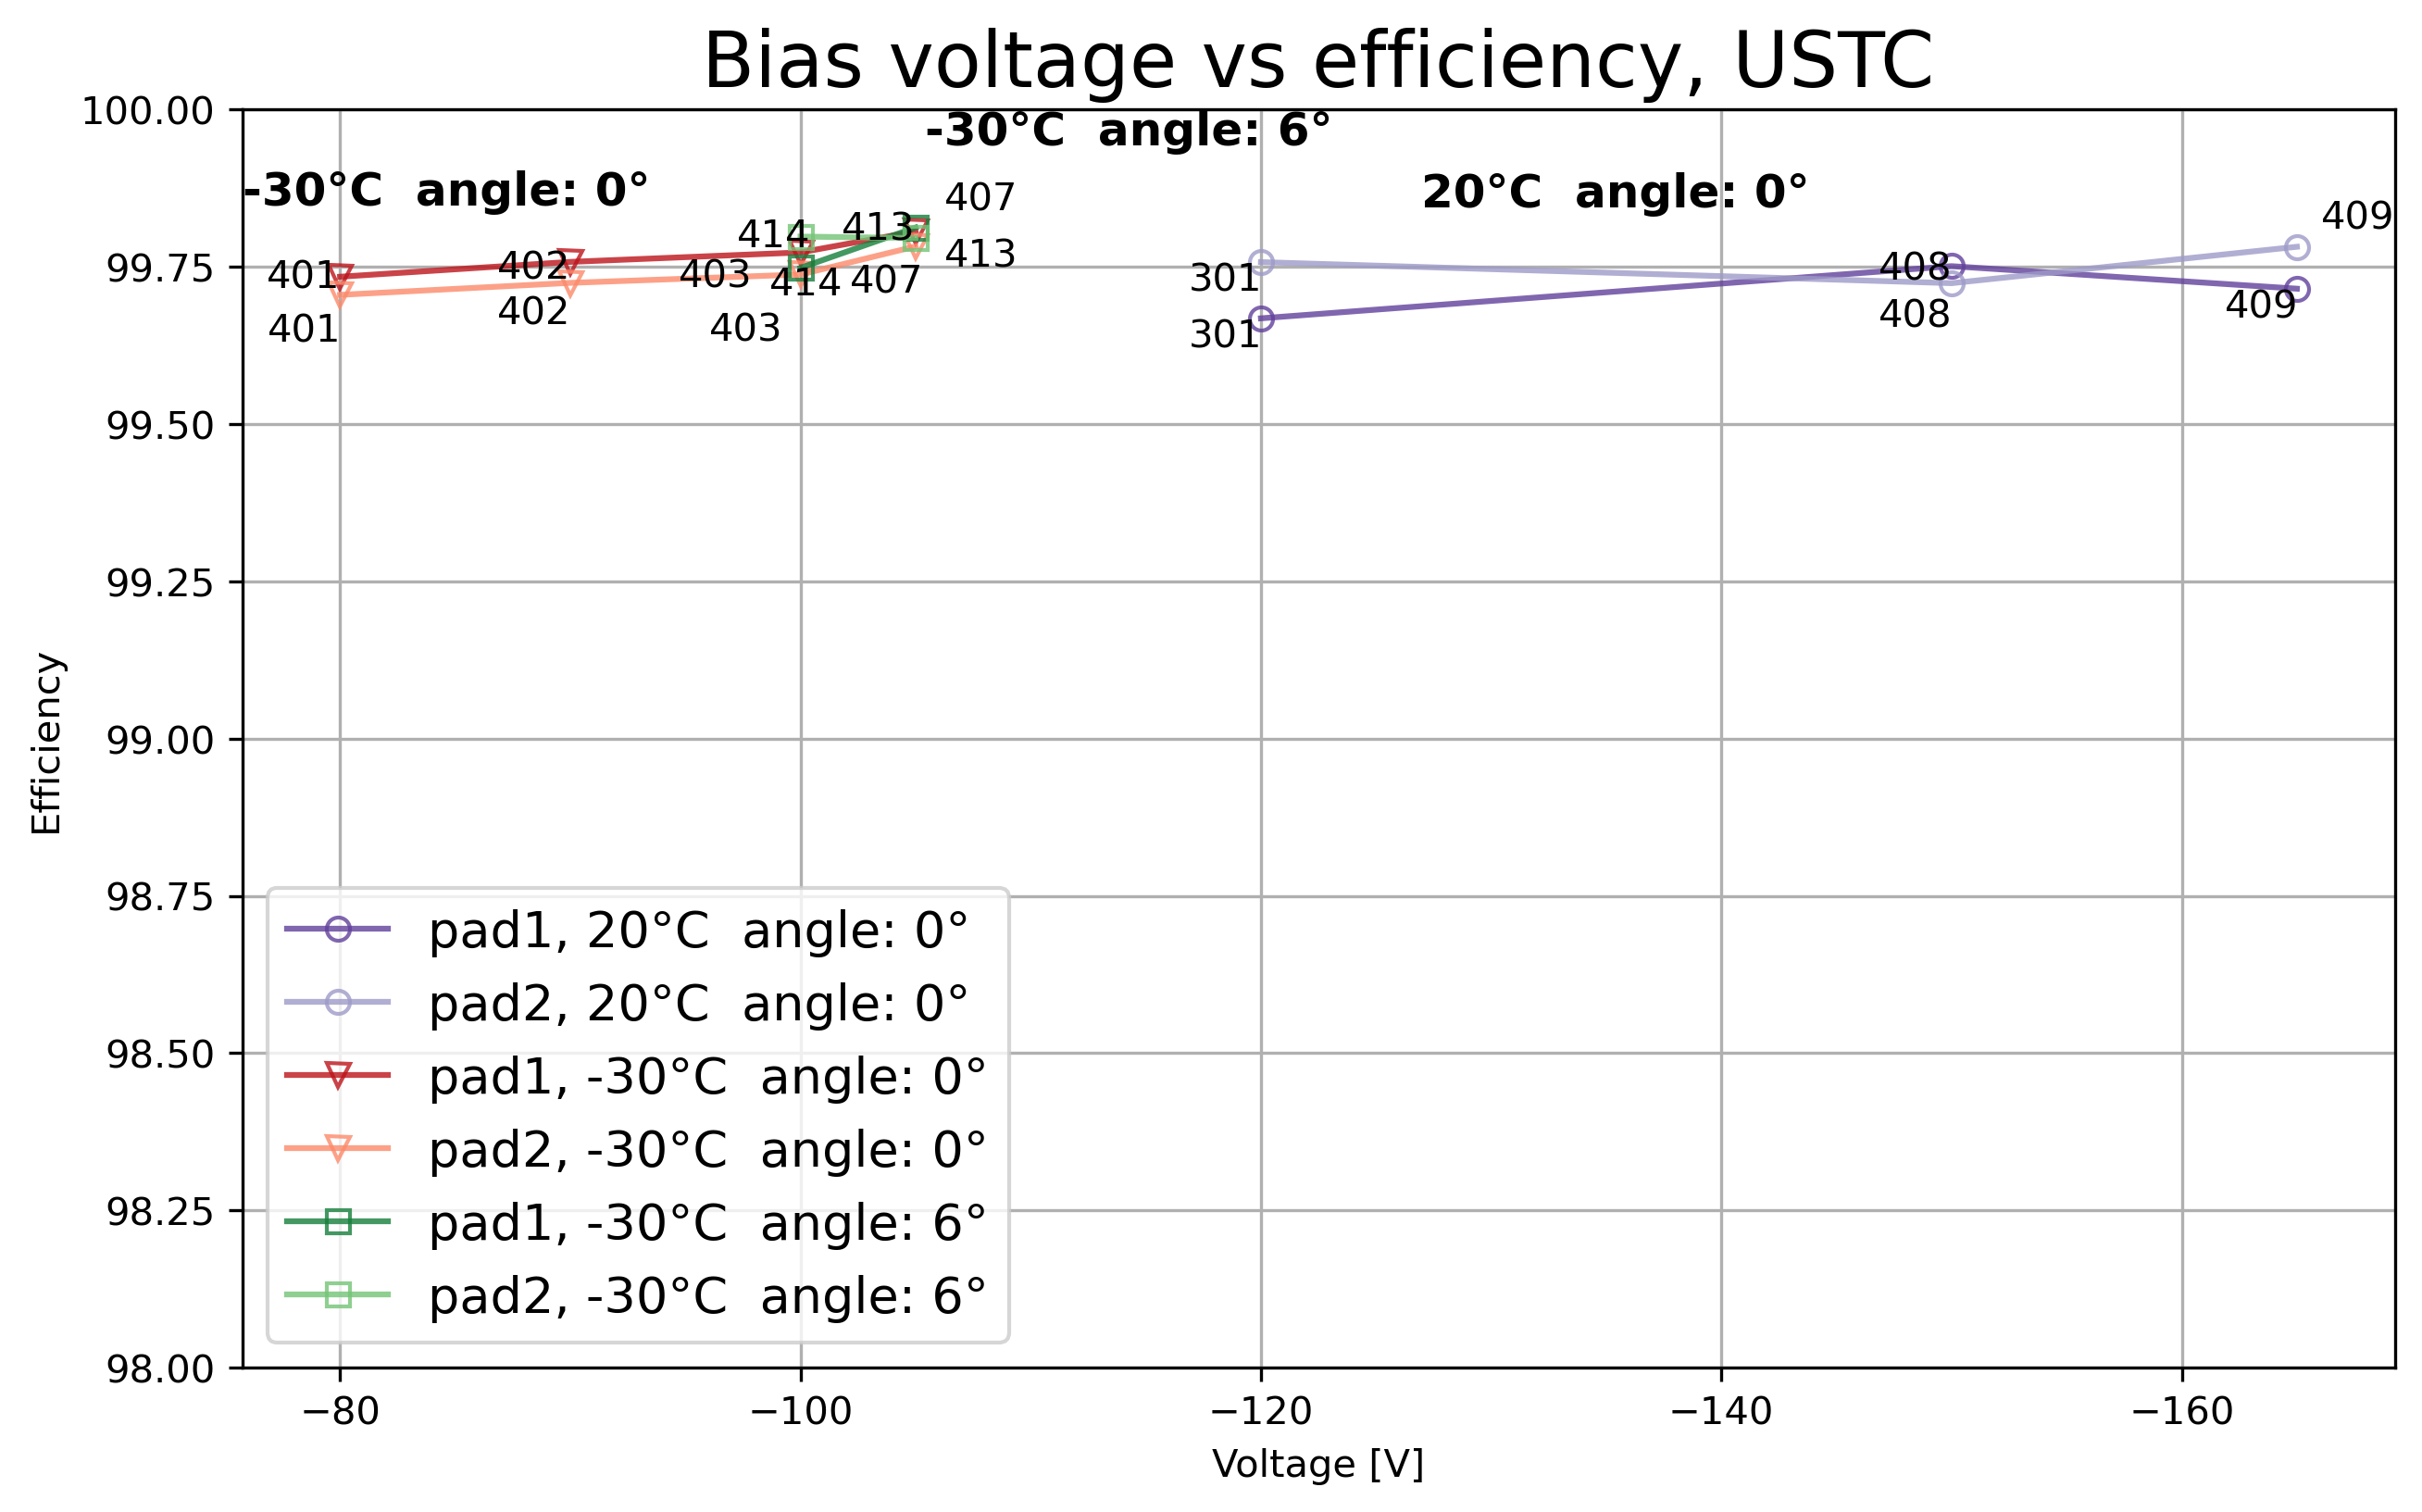

In [68]:
### EFFICIENCY

fig, ax = plt.subplots(figsize=(10,6), dpi=300)

# labels = ['room temperature', '-30°C','angle: 6° (MCP:2800V)']
list_of_texts = []
for j,key in enumerate(['room_temp', 'normal','angled']):
    df_analysis = dict_analysis_USTC[key]
    df_analysis = df_analysis.loc[df_analysis['exclude']==False]
    
    for k,ch in enumerate(['Ch2','Ch3']):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        eff = np.array(df_analysis.loc[idx[:,:,ch]]['efficiency'])
        batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))

        ax.plot(voltage, eff,
            marker=markers[j], markersize=6, alpha=0.8, color=USTC_colormap[2*j+k], mfc='none',
            label=f"{dut_labels[k]}, {labels_for_keys[key]}")
        if BATCH_LABELS:
            for x,y,label in zip(voltage,eff,batch_labels):
                list_of_texts.append(ax.text(x, y, label))
    list_of_texts.append(ax.text(np.mean(voltage[0:2]), np.mean(eff[0:2])+.1, labels_for_keys[key],
                                 fontsize='large', weight='bold'))

# ax.axhline(35, linestyle='--', color='grey', label="Resolution target")
# ax.axhline(70, linestyle='--', color='grey')

ax.set_title(f"Bias voltage vs efficiency, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Efficiency")
ax.set_ylim(98,100)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=13)

### this needs to be last
adjust_text(list_of_texts)

if SAVE:
    fig.savefig(f"../various plots/{this_sensor}/USTC_plots_together_voltage_efficiency_{if_labels}.png", bbox_inches='tight')


In [69]:
# def get_DUT_from_index(index_list):
#     """
#     Simple function to get a list of DUT numbers directly from the index, 
#     """
#     DUT_list = []
#     for ch in index_list:
#         match ch:
#             case 'Ch2' | 'ch2' | 'Ch_2' | 'ch_2': DUT_list.append(1)
#             case 'Ch3' | 'ch3' | 'Ch_3' | 'ch_3': DUT_list.append(2)
#             case 'Ch4' | 'ch4' | 'Ch_4' | 'ch_4': DUT_list.append(3)
#     return DUT_list

In [60]:
SAVE = False

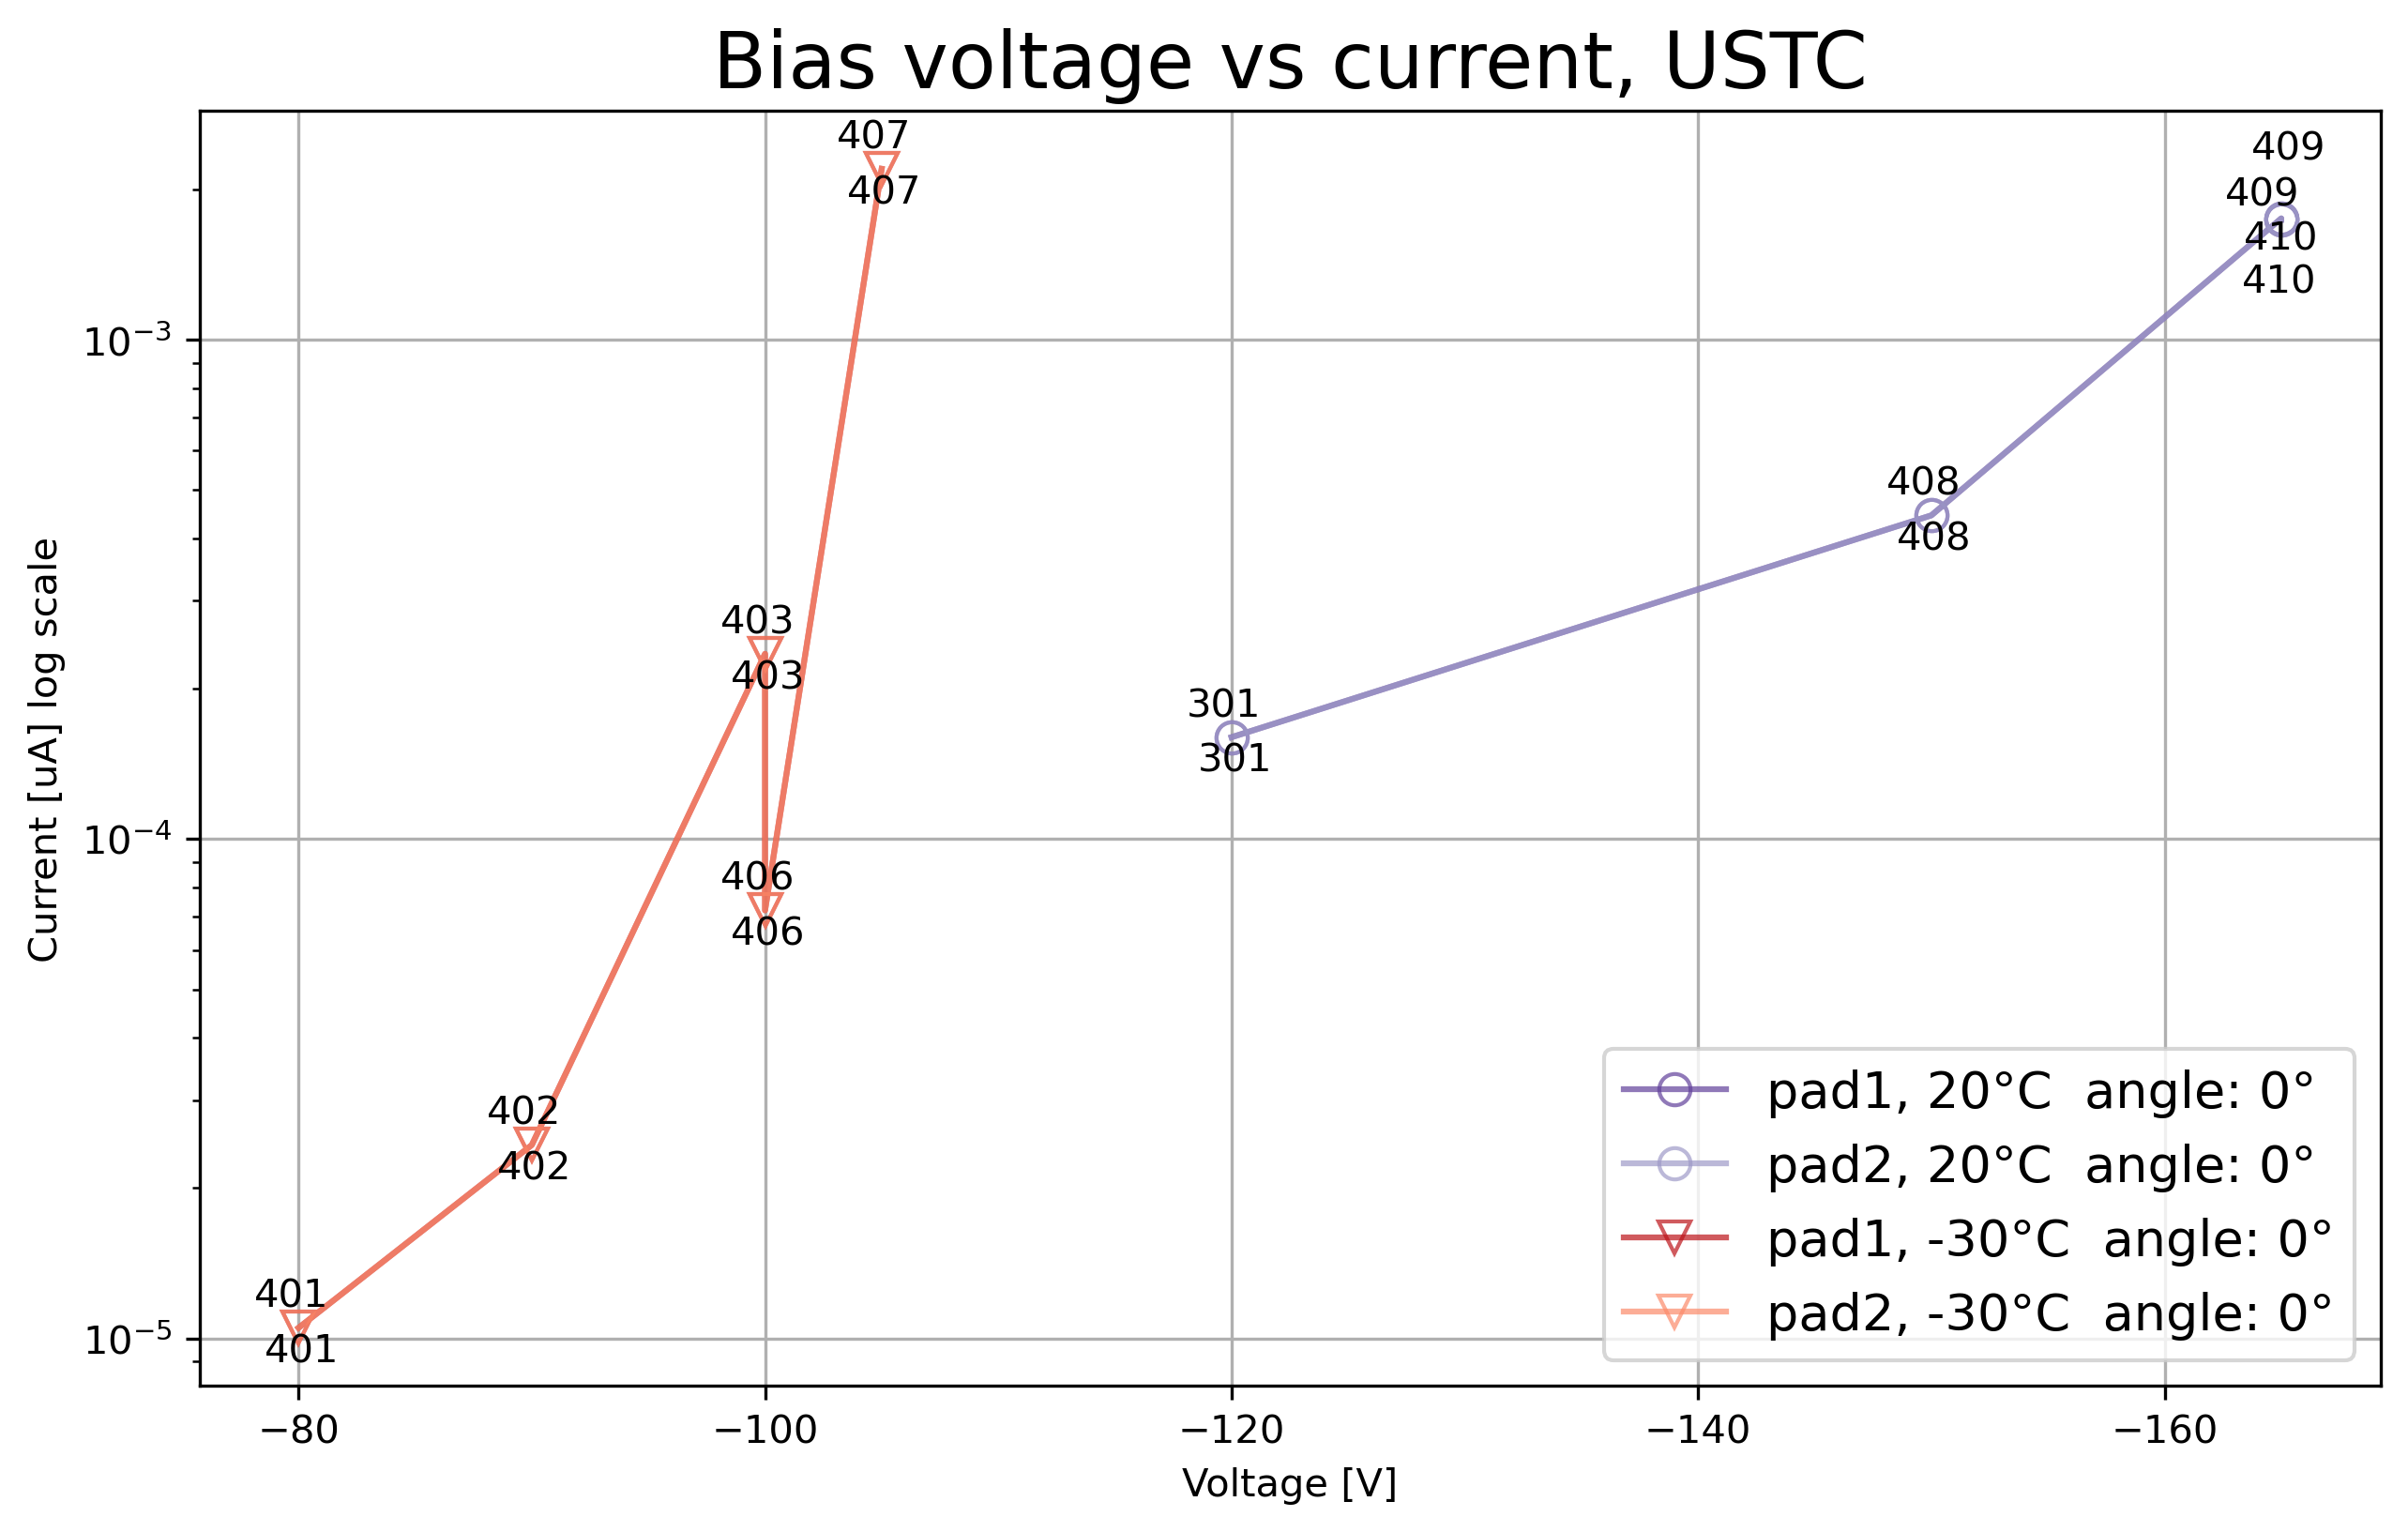

In [62]:
## plotting with the current to try to understand what's going on between 403 and 406

fig, ax = plt.subplots(figsize=(10,6), dpi=300)

# labels = ['room temperature', '-30°C','angle: 6° (MCP:2800V)']

list_of_texts = []
for j,key in enumerate(['room_temp','normal']): # ['room_temp', 'normal','angled']
    df_analysis = dict_analysis_USTC[key]
#     df_analysis = df_analysis.loc[df_analysis['exclude']==False]
    
    for k,ch in enumerate(df_analysis.index.unique(2)):
        voltage = np.array(df_analysis.loc[idx[:,:,ch]]['voltage'])
        current = np.array(df_analysis.loc[idx[:,:,ch]]['current']).astype(np.float64)*1e3
#         time_err = np.array(df_analysis.loc[idx[:,:,ch]]['time_resolution_error'])
#         ax.errorbar(voltage, current, yerr=time_err, ecolor='k', capsize=4,
        ax.plot(voltage, current,
            marker=markers[j], color=USTC_colormap[2*j+k],
            label=f"{dut_labels[k]}, {labels_for_keys[key]}", **marker_settings)
        ### list of all batc numbers
        batch_labels = np.array(df_analysis.loc[idx[:,:,ch]].index.get_level_values('batch'))
        for x,y,label in zip(voltage,current,batch_labels):
            ### add a random shift, otherwise identical labels don't get moved by 'adjust_text'
            random_shift = np.random.uniform(low=-1e-9,high=1e-9)
            list_of_texts.append(ax.text(x, y+random_shift, label))
#     list_of_texts.append(ax.text(np.mean(voltage[0:2]), np.mean(current[0:2]-1), labels_for_keys[key],
#                                  fontsize='large', weight='bold'))
            
# ax.axhline(35, linestyle='--', color='grey', label="Resolution target")
# ax.axhline(70, linestyle='--', color='grey')

log_scale = "log scale"
# log_scale = ""
if log_scale:
    ax.semilogy()
    
ax.set_title(f"Bias voltage vs current, USTC", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel(f"Current [uA] {log_scale}")
# ax.set_ylim(30,75)
ax.invert_xaxis()



ax.grid('--')
ax.legend(fontsize=13)

adjust_text(list_of_texts)

if SAVE:
    fig.savefig(f"../various plots/{this_sensor}/USTC_plots_together_voltage_current_{if_labels}_{log_scale}.png", bbox_inches='tight')


In [32]:
dict_analysis_USTC['normal']['current'].to_numpy()

array([2.2e-06, 2.2e-06, 2.35e-07, 2.35e-07, 7.2e-08, 7.2e-08, 2.44e-08,
       2.44e-08, 1.05e-08, 1.05e-08], dtype=object)

# CNM
looking specifically at one sensor

In [ ]:
this_sensor = 'CNM'
IME_names = set()
for name in unique_names:
    if this_sensor in name:
        print(name)
        IME_names.add(name)


Chi^2 formula:
$$
\chi^2 = \sum_i^N \frac{(E_i-O_i)^2}{E_i}\\
\chi^2_{reduced} = \frac{\chi^2}{N-d.o.f}
$$

In [1]:
fig,ax = plt.subplots(figsize=(20,12), dpi=300)
for batch, S, ch in dict_analysis_IME['angled'].index:
    print(batch,S,ch)
    df = load_batch(batch,S)
    match ch:
        case 'Ch2': dut = 1
        case 'Ch3': dut = 2
        case 'Ch4': dut = 3
    DUTs = [dut]
#     geo_cuts, geo_infos = zip(*[geometry_mask(df, DUT_number=dut, bins=large_bins, bins_find_min='rice', only_select='normal', use='pulseheight')
#                                 if dut in DUTs else (None,None) for dut in [1,2,3]])
    plot_histogram(df[f'charge_{dut}']/4700, bins=1000, fig_ax=(fig,ax), label=f"{batch}, {S}, {ch}")
ax.semilogy()
ax.set_xlim(-50,300)
ax.legend()

NameError: name 'plt' is not defined